# 數字影像辨識

## 載入工具

In [1]:
import os
import pandas as pd
from pandas import DataFrame
from keras.models import Sequential, Model, load_model, Model
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
# matplotlib.use("TkAgg")
%matplotlib inline
import numpy as np
np.random.seed(1)
from sklearn.metrics import confusion_matrix
from PIL import Image
import random
import math

Using TensorFlow backend.


## 資料：訓練集、測試集

MNIST 是 Mixed National Institute of Standards and Technology database 的簡稱 http://yann.lecun.com/exdb/mnist/
- MNIST 是一個數據庫，這個數據庫中存儲了各個國家地區，不同標準的手寫數字，存儲的內容都是結果標準化處理了的，專門用於關於手寫體識別
- MNIST 數據集來自美國國家標準與技術研究所, National Institute of Standards and Technology (NIST)
- 訓練集 (training set) 由來自 250 個不同人手寫的數字構成, 其中 50% 是高中學生, 50% 來自人口普查局 (the Census Bureau) 的工作人員
- 測試集(test set) 也是同樣比例的手寫數字數據.

MNIST 數據集可在 http://yann.lecun.com/exdb/mnist/ 獲取, 它包含了四個部分:
- 訓練圖片集合: train-images-idx3-ubyte.gz (包含 60,000 個圖片樣本)
- 訓練標籤集合: train-labels-idx1-ubyte.gz (包含 60,000 個數字標籤)
- 測試圖片集合: t10k-images-idx3-ubyte.gz (包含 10,000 個圖片樣本)
- 測試標籤集合: t10k-labels-idx1-ubyte.gz (包含 10,000 個數字標籤)

數據內容：
- mnist.train.image: 是一個 ndarray，裡面每一個元素是用來訓練的圖片數據
- mnist.train.image[index]: 是一個大小為 (784, ) 的 ndarray
- 裡面每一個元素代表這個圖片【標準化為 28*28 大小的正方形】在每個像素框中的像素值【或者是灰度值】

- mnist.train.labels: 是一個 ndarray，裡面的每一個元素指 mnist.train.image 中根據下標對應的圖片真實代表值
- mnist.train.labels[index]: 是一個大小為 (10, ) 的 ndarray
- 裡面每一個元素只有 0，1 兩種取值，代表了 mnist.train.image[index] 這個圖片對應的真實值

In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('x_train\n', x_train.shape)
print('y_train\n', y_train.shape, y_train[0])
print('x_test\n', x_test.shape)
print('y_test\n', y_test.shape)

x_train
 (60000, 28, 28)
y_train
 (60000,) 5
x_test
 (10000, 28, 28)
y_test
 (10000,)


## 數據前處理

In [3]:
# data pre-processing
x_train = x_train.reshape(-1, 1, 28, 28)/255.
x_test  = x_test.reshape(-1, 1, 28, 28)/255.
y_train = np_utils.to_categorical(y_train, num_classes=10)
y_test  = np_utils.to_categorical(y_test, num_classes=10)

## 觀察樣本

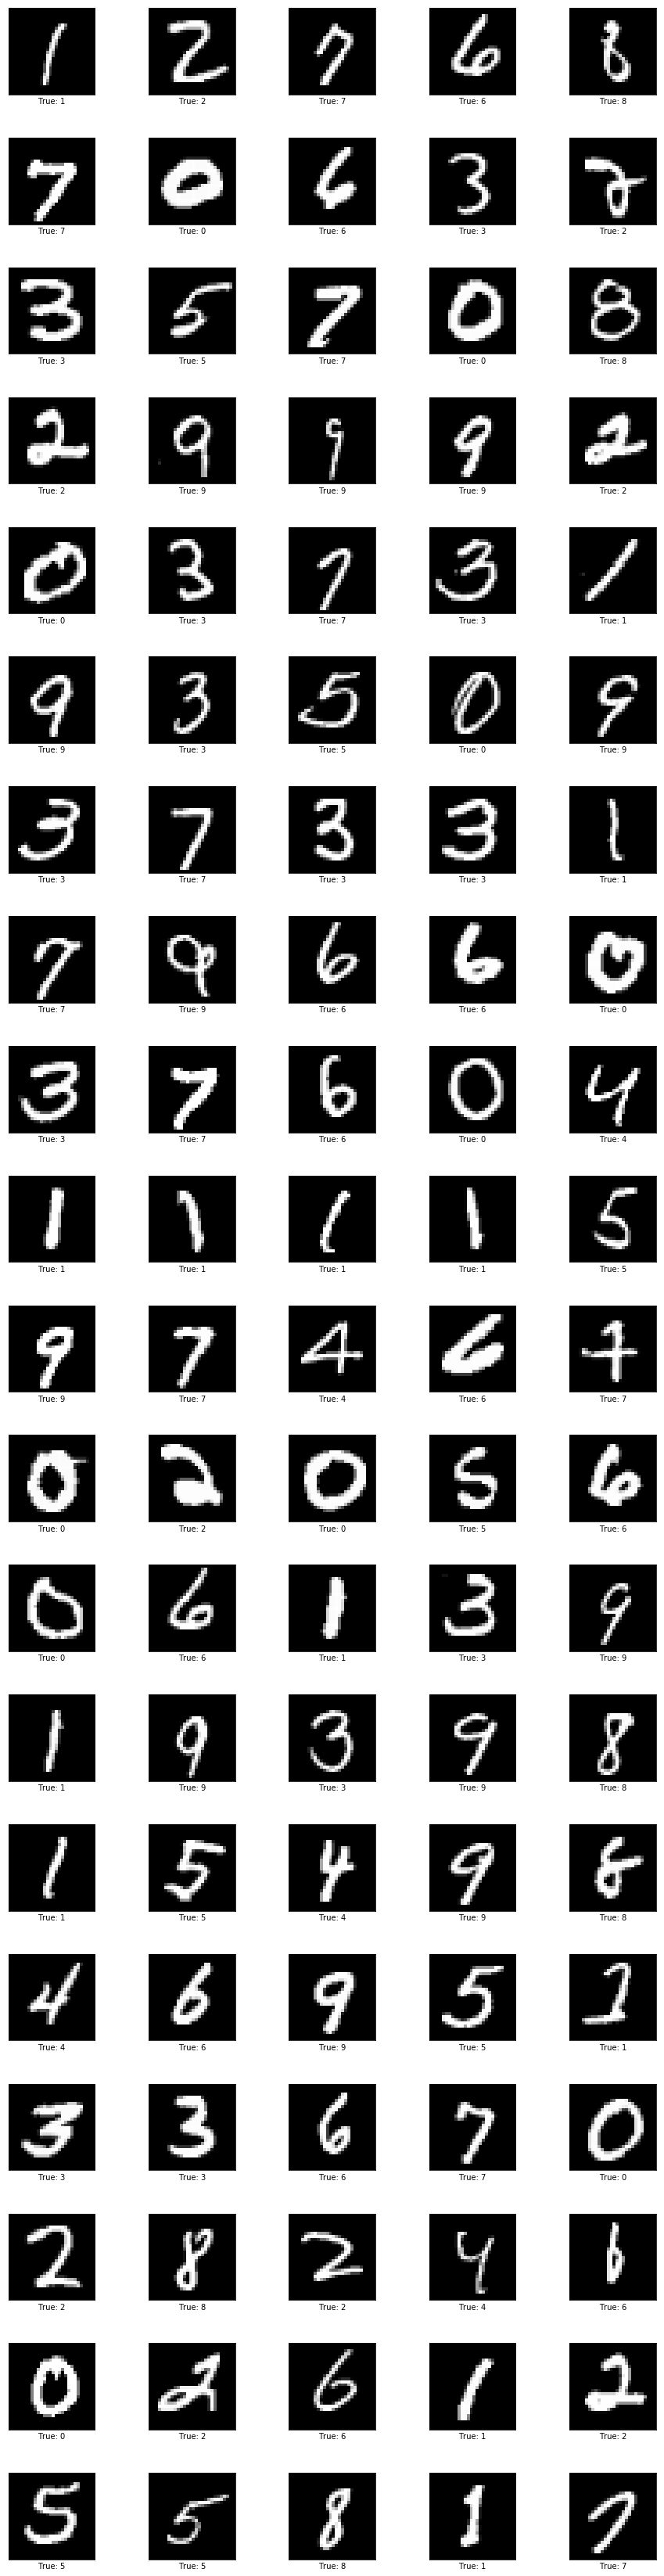

In [4]:
num = 100
row = int(math.ceil(num/5))

fig, axes = plt.subplots(row, 5, figsize=(5*3, row*3))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, ax in enumerate(axes.flat):
    r = random.randint(0, len(x_train) - 1)
    x_test_random = x_train[r:r+1]
    y_test_random = y_train[r:r+1]
    ax.imshow(x_test_random.reshape(28, 28), cmap="gray")
    ax.set_xlabel("True: {0}".format(np.argmax(y_test_random, 1)[0]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## 建構 Model

In [5]:
model = Sequential()

model.add(Convolution2D(
    batch_input_shape=(None, 1, 28, 28),
    filters=32,
    kernel_size=5,
    strides=1,
    padding='same',     # Padding method
    data_format='channels_first',
))
model.add(Activation('relu'))

# Pooling layer 1 (max pooling) output shape (32, 14, 14)
model.add(MaxPooling2D(
    pool_size=2,
    strides=2,
    padding='same',
    data_format='channels_first',
))

# Conv layer 2 output shape (64, 14, 14)
model.add(Convolution2D(
    filters=64, 
    kernel_size=5, 
    strides=1, 
    padding='same', 
    data_format='channels_first'
))
model.add(Activation('relu'))

# Pooling layer 2 (max pooling) output shape (64, 7, 7)
model.add(MaxPooling2D(
    pool_size=2, 
    strides=2, 
    padding='same', 
    data_format='channels_first'
))

# Fully connected layer 1 input shape (64 * 7 * 7) = (3136), output shape (1024)
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))

# Fully connected layer 2 to shape (10) for 10 classes
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

W0708 13:58:51.076130 4555318720 deprecation_wrapper.py:119] From /Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 13:58:51.090004 4555318720 deprecation_wrapper.py:119] From /Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 13:58:51.092041 4555318720 deprecation_wrapper.py:119] From /Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0708 13:58:51.101175 4555318720 deprecation_wrapper.py:119] From /Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is de

## Load Model

In [6]:
# del model  # deletes the existing model
# model = load_model('./model.h5')

## 訓練 Model

In [7]:
model.fit(x_train, y_train, epochs=1, batch_size=64)

W0708 13:58:51.247483 4555318720 deprecation.py:323] From /Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
60000/60000 [==============================] - 72s 1ms/step - loss: 0.2192 - acc: 0.9322


## Save Model

In [8]:
model.save('./model.h5')  # HDF5 file, you have to pip3 install h5py if don't have it
print('Saved')

Saved


## 預測新資料

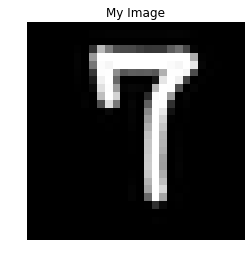

4


In [9]:
def predict_image_with_path(file_path):
    im = Image.open(file_path)
    im = im.convert('L')
    im = im.resize((28, 28), Image.ANTIALIAS)  # resize the image
    im = np.array(im)  # convert to an array
#         im = np.ones(im.shape)*255 - im # reversed white and black
    im2 = im / np.max(im).astype(float)  # normalise input

    plt.imshow(im2, cmap='gray')
    plt.title('My Image')
    plt.axis('off')
    plt.show()

    test_image = np.reshape(im2, [1, 1, 28, 28])  # reshape it to our input placeholder shape
    predict = model.predict(test_image).argmax(axis=1)
    return test_image, predict

x_image, y_image_predict = predict_image_with_path("./my_image1.png")
print(y_image_predict[0])

## 增加新資料

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


/Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (10, 1, 28, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


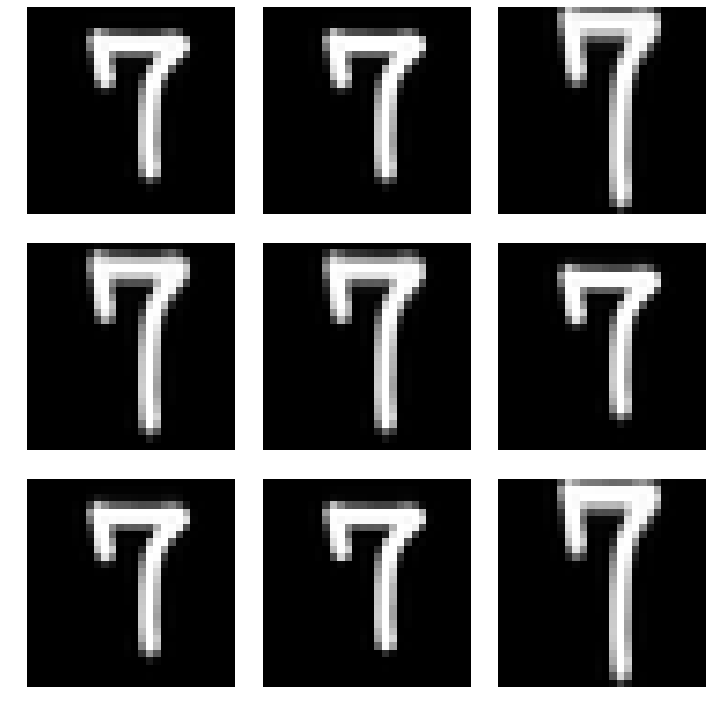

In [12]:
def augmentation(x_image, y_image, batch=10):
    x_images = x_image.repeat(batch, axis=0)
    y_images = y_image.repeat(batch, axis=0)
    datagen = ImageDataGenerator(rotation_range=45)
    aug_data = datagen.flow(x_images, y_images, batch_size=batch, shuffle = False)
    x_batch, y_batch = aug_data[0]
    # 畫圖    
    for i in range(len(x_batch)):
        fig, axes = plt.subplots(3, 3, figsize=(10,10))
        axes = axes.flatten()
        for i in range(len(x_batch)-1):
            axes[i].imshow(x_batch[i].reshape(28, 28), cmap='gray')
            axes[i].axis('off')
        plt.tight_layout()
        break
    return x_batch, y_batch

y_image_real = np_utils.to_categorical(np.array([[7]]), num_classes=10)
print(y_image_real)
x_batch, y_batch = augmentation(x_image, y_image_real)

## 加入新資料訓練

In [13]:
x_train = np.vstack([x_train, x_batch])
y_train = np.vstack([y_train, y_batch])
model.fit(x_train, y_train, epochs=1, batch_size=64)

Epoch 1/1
60010/60010 [==============================] - 68s 1ms/step - loss: 0.0966 - acc: 0.9714


## 確認學習新資料

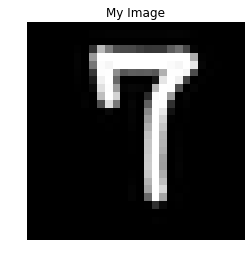

7


In [14]:
x_image, y_image_predict = predict_image_with_path("./my_image1.png")
print(y_image_predict[0])

## 評估辨識能力

[[ 969    1    1    0    0    0    3    2    4    0]
 [   1 1117    6    0    2    0    2    2    5    0]
 [   5    1  999    2    5    0    1   10    9    0]
 [   1    0    7  973    0   12    0    4    9    4]
 [   0    2    0    0  943    0    8    3    5   21]
 [   1    0    0    2    0  858    5    1   21    4]
 [   8    2    0    0    1    0  937    0   10    0]
 [   0    4    3    3    0    1    0 1010    2    5]
 [   2    3    3    1    0    0    2    2  960    1]
 [   2    6    1    1    6    2    1    9   11  970]]


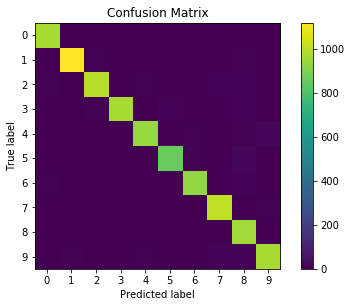

In [15]:
# Confusion Matrix 混淆矩陣
p_class_test = model.predict(x_test).argmax(axis=1)
y_class_test = y_test.argmax(axis=1)
cm = confusion_matrix(y_class_test, p_class_test)
print(cm)

# Plotting confusion Matrix
plt.imshow(cm, interpolation='nearest')
plt.colorbar()
number_of_class = len(np.unique(y_class_test))
tick_marks = np.arange(len(np.unique(y_class_test)))
plt.xticks(tick_marks, range(number_of_class))
plt.yticks(tick_marks, range(number_of_class))
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

## 查找錯誤

total num: 10000
error num: 264


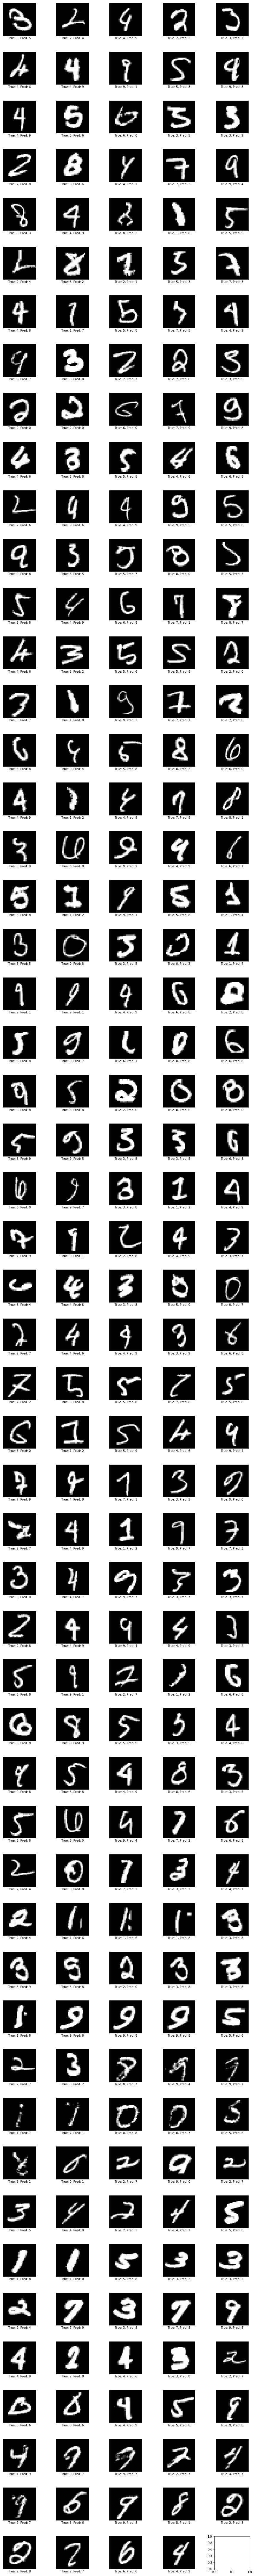

In [16]:
#Finding error outputs
idx = p_class_test == y_class_test
cmp = np.where(idx == False) #indices of error outputs
print('total num:', idx.shape[0])
print('error num:', len(cmp[0]))

# plotting errors
num = len(cmp[0])
row = int(math.ceil(num/5))

fig, axes = plt.subplots(row, 5, figsize=(5*3, row*3))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
cls_true = y_class_test[cmp]
cls_pred = p_class_test[cmp]
images = x_test[cmp]

for i, ax in enumerate(axes.flat):
    if i >= len(cmp[0]):
        break
    ax.imshow(images[i].reshape(28,28), cmap='gray')
    xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
    ax.set_xlabel(xlabel)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 28, 28)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 28, 28)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 14, 14)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 14, 14)        51264     
_________________________________________________________________
activation_2 (Activation)    (None, 64, 14, 14)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 7, 7)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
__________

## 卷積層filter所認的特徵

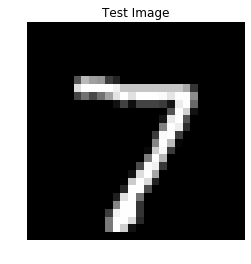

(1, 32, 28, 28)


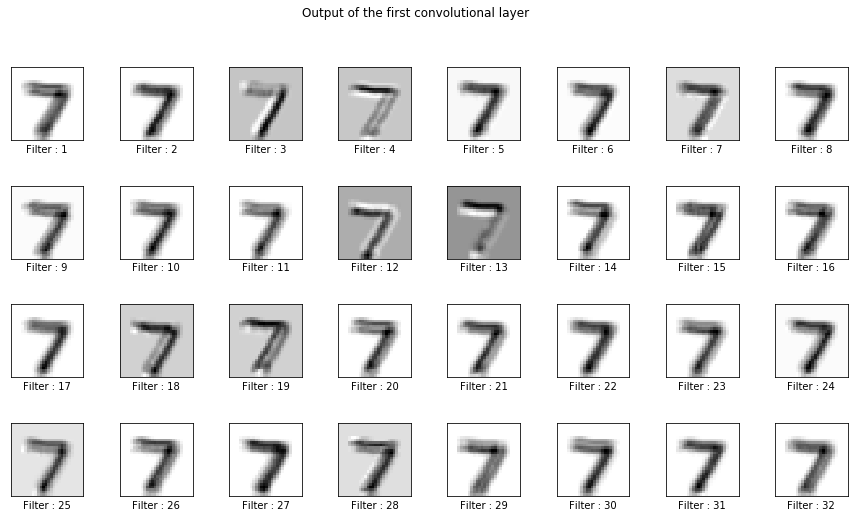

In [18]:
test_image = np.reshape(x_test[0], [1, 1, 28, 28])
plt.imshow(np.reshape(test_image, [28, 28]), cmap='gray')
plt.title('Test Image')
plt.axis('off')
plt.show()

layer_model = Model(inputs=model.input, outputs=model.get_layer('conv2d_1').output)
conv1_ = layer_model.predict(test_image)
print(conv1_.shape)

conv1_img_ = conv1_[0,:,:,:]
fig, axes = plt.subplots(4, 8, figsize=(15, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, ax in enumerate(axes.flat):
    ax.imshow(conv1_img_[i,:,:], cmap='gray')
    xlabel = "Filter : {}".format(i+1)
    ax.set_xlabel(xlabel)
    ax.set_xticks([])
    ax.set_yticks([])      
fig.suptitle('Output of the first convolutional layer')  
plt.show()